In [13]:
from transformers import (
    TokenClassificationPipeline,
    AutoModelForTokenClassification,
    AutoTokenizer,
)
from transformers.pipelines import AggregationStrategy
import numpy as np

# Define keyphrase extraction pipeline
class KeyphraseExtractionPipeline(TokenClassificationPipeline):
    def __init__(self, model, *args, **kwargs):
        super().__init__(
            model=AutoModelForTokenClassification.from_pretrained(model),
            tokenizer=AutoTokenizer.from_pretrained(model),
            *args,
            **kwargs
        )

    def postprocess(self, all_outputs):
        results = super().postprocess(
            all_outputs=all_outputs,
            aggregation_strategy=AggregationStrategy.SIMPLE,
        )
        return np.unique([result.get("word").strip() for result in results])


# Load pipeline
model_name = "ml6team/keyphrase-extraction-kbir-kpcrowd"
extractor = KeyphraseExtractionPipeline(model=model_name)

# Inference
text = """
Keyphrase extraction is a technique in text analysis where you extract the
important keyphrases from a document. Thanks to these keyphrases humans can
understand the content of a text very quickly and easily without reading it
completely. Keyphrase extraction was first done primarily by human annotators,
who read the text in detail and then wrote down the most important keyphrases.
The disadvantage is that if you work with a lot of documents, this process
can take a lot of time. 

Here is where Artificial Intelligence comes in. Currently, classical machine
learning methods, that use statistical and linguistic features, are widely used
for the extraction process. Now with deep learning, it is possible to capture
the semantic meaning of a text even better than these classical methods.
Classical methods look at the frequency, occurrence and order of words
in the text, whereas these neural approaches can capture long-term
semantic dependencies and context of words in a text.
""".replace("\n", " ")

keyphrases = extractor(text)

print(keyphrases)


['Artificial Intelligence' 'Classical' 'Keyphrase' 'Keyphrase extraction'
 'classical' 'content' 'context' 'disadvantage' 'document' 'documents'
 'extract' 'extraction' 'extraction process' 'frequency' 'human' 'humans'
 'important' 'keyphrases' 'learning' 'linguistic' 'long-term'
 'machine learning' 'meaning' 'methods' 'neural approaches' 'occurrence'
 'process' 'quickly' 'semantic' 'statistical' 'technique' 'text'
 'text analysis' 'understand' 'widely' 'words' 'work']


In [1]:
import pandas as pd


df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/wiki-sci-2-w-sentence-context/test_1.csv")


def get_context(text):
    x = text.split(" ### ")
    # remove empty strings
    x = [x for x in x if len(x) > 0]
    
    assert len(x) == 2, f"Unsuccesful prompt splitting . len(x) = {len(x)}, x={x}"
    return x[0]


df['context'] = df['prompt'].apply(lambda x: get_context(x))

def get_prompt(text):
    x = text.split(" ### ")
    # remove empty strings
    x = [x for x in x if len(x) > 0]
    assert len(x) == 2, f"Unsuccesful prompt splitting . len(x) = {len(x)}"
    return x[1]

df['prompt'] = df['prompt'].apply(lambda x: get_prompt(x))

df

,id,prompt,A,B,C,D,E,answer,context
0,0,Which of the following statements accurately ...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,Context: The homogeneously distributed mass of...
1,1,Which of the following is an accurate definit...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,"Context: To describe these systems, it is conv..."
2,2,Which of the following statements accurately ...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,"Context: ""Caput Medusae"" [Latin] means ""Head o..."
3,3,What is the significance of regularization in...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,Context: (Another way to avoid the infinity...
4,4,Which of the following statements accurately ...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,"Context: The finer the grating spacing, the gr..."
...,...,...,...,...,...,...,...,...,...
155,155,What is the significance of the redshift-dist...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,E,Context: Observations of the redshift-distance...
156,156,What is the Evans balance?,The Evans balance is a system used to measure ...,The Evans balance is a system used to measure ...,The Evans balance is a system used to measure ...,The Evans balance is a system used to measure ...,The Evans balance is a system used to measure ...,D,"Context: An Evans balance, also known as a Joh..."
157,157,What is the definition of dimension in mathem...,The dimension of an object is the number of in...,The dimension of an object is the number of de...,The dimension of an object is the number of in...,The dimension of an object is the number of di...,The dimension of an object is the number of di...,C,"Context: For example, the dimension of a point..."
158,158,What is accelerator-based light-ion fusion?,Accelerator-based light-ion fusion is a techni...,Accelerator-based light-ion fusion is a techni...,Accelerator-based light-ion fusion is a techni...,Accelerator-based light-ion fusion is a techni...,Accelerator-based light-ion fusion is a techni...,A,Context: Heavy ion fusion is a fusion energy c...


In [9]:
df_2 = pd.concat([df[df['answer']=='A'].reset_index(), df[df['answer']!='A'].reset_index()]).reset_index()

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('../data/huggingface_hub_models/bge-large-en')
df_2['A_embd'] = df_2['A'].apply(lambda x: model.encode(x, normalize_embeddings=True))
df_2['B_embd'] = df_2['B'].apply(lambda x: model.encode(x, normalize_embeddings=True))

df_2


,level_0,index,id,prompt,A,B,C,D,E,answer,context,A_embd,B_embd
0,0,1,1,Which of the following is an accurate definit...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,"Context: To describe these systems, it is conv...","[-0.01208058, 0.019715527, 0.0041762074, 0.008...","[-0.011517408, 0.022221316, 0.0028631259, 0.00..."
1,1,2,2,Which of the following statements accurately ...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,"Context: ""Caput Medusae"" [Latin] means ""Head o...","[-0.023716932, -0.004121764, 0.0021551885, -0....","[-0.020189397, -0.018377911, 0.011373364, -0.0..."
2,2,6,6,Which of the following statements accurately ...,The dimension of an object in a CW complex is ...,The dimension of an object in a CW complex is ...,The dimension of an object in a CW complex is ...,The dimension of an object in a CW complex is ...,The dimension of an object in a CW complex dep...,A,"Context: Moreover, the boundary of a discrete ...","[-0.0142836, -0.00469881, 0.02277209, 0.009344...","[-0.01431576, -0.012617971, 0.03207832, -0.005..."
3,3,9,9,What is the role of axioms in a formal theory?,Basis statements called axioms form the founda...,Axioms are supplementary statements added to a...,Axioms are redundant statements that can be de...,The axioms in a theory are used for experiment...,The axioms in a formal theory are added to pro...,A,Context: All theorems are derived from axioms....,"[-0.026672935, -0.018148981, 0.028767651, -0.0...","[-0.015753282, -0.02319973, 0.019032933, -0.02..."
4,4,11,11,What is the relationship between the Wigner f...,"The Wigner function W(x, p) is the Wigner tran...","The Wigner function W(x, p) is a source functi...","The Wigner function W(x, p) is the derivative ...","The Wigner function W(x, p) represents the Ham...","The Wigner function W(x, p) is the time deriva...",A,Context: Thus the trace of an operator with th...,"[-0.024776332, 0.005570391, 0.021095948, -0.00...","[-0.014773105, 0.015633557, 0.022741692, -0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,125,151,151,What was Isaac Newton's explanation for recti...,Isaac Newton rejected the wave theory of light...,Isaac Newton rejected the wave theory of light...,Isaac Newton accepted the wave theory of light...,Isaac Newton rejected the wave theory of light...,Isaac Newton accepted the wave theory of light...,D,"Context: About a half-century after Gassendi, ...","[-0.007211168, -0.020892957, -0.0082666725, -0...","[-0.0066040354, -0.02150118, -0.008600961, -0...."
156,126,154,154,What are the two main factors that cause resi...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,The amount of resistance in a metal is mainly ...,B,"Context: At high temperatures, the resistance ...","[-0.032869413, 0.0041922266, -0.0052425433, 0....","[-0.039163552, 0.010580609, -0.01004499, 0.031..."
157,127,155,155,What is the significance of the redshift-dist...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,Observations of the redshift-distance relation...,E,Context: Observations of the redshift-distance...,"[-0.007350597, 0.04000835, 0.024161132, 0.0230...","[-0.00033125145, 0.04472625, 0.018193165, 0.02..."
158,128,156,156,What is the Evans balance?,The Evans balance is a system used to measure ...,The Evans balance is a system used t

In [19]:
import numpy as np

df_2_correct = df_2[df_2['answer'] == 'A']
for i in range(len(df_2_correct)):
    prompt = df_2_correct.iloc[i]['context']
    answer_embd = df_2_correct.iloc[i]['A_embd']
    
    sentences = prompt.split(".")
    for s in sentences:
        y = model.encode(s, normalize_embeddings=True)
        
        # calculate cosine similarity of answer_embd with y
        inner_product = np.dot(answer_embd, y)
        print(inner_product) 
    
    break

0.8582725
0.81591904
0.83765817
0.8601697
0.7606584
0.8970957
0.7814526
0.83085287
0.8343147
0.782843
0.8345454
0.77990043
0.8344488


In [20]:
import numpy as np

df_2_correct = df_2[df_2['answer'] == 'B']
for i in range(len(df_2_correct)):
    prompt = df_2_correct.iloc[i]['context']
    answer_embd = df_2_correct.iloc[i]['A_embd']
    
    sentences = prompt.split(".")
    for s in sentences:
        y = model.encode(s, normalize_embeddings=True)
        
        # calculate cosine similarity of answer_embd with y
        inner_product = np.dot(answer_embd, y)
        print(inner_product) 
    
    break

0.8639213
0.9082133
0.82818645
0.8957026
0.857839
0.86618394
0.9002947
0.79870975
0.78744185
0.8704318
0.891591
0.8206303


In [83]:

indx = 21

print("FIRST 400", "----"*128)
print("CONTEXT: ", df.iloc[indx]['context'][:400])
print("\n")
print("ALL 2000", "----"*128)
print("CONTEXT: ", df.iloc[indx]['context'][:2000])
print("PROMPT", "----"*128)
print("\n")
print(df.iloc[indx]['prompt'])
print("\n")
print(len(df.iloc[indx]['prompt']))
print("\n")
print(df.iloc[indx][df.iloc[indx]['answer']])
print("----"*128)
print('A', df.iloc[indx]['A'])
print("----"*128)
print('B', df.iloc[indx]['B'])
print("----"*128)
print('C', df.iloc[indx]['C'])
print("----"*128)
print('D', df.iloc[indx]['D'])
print("----"*128)
print('E', df.iloc[indx]['E'])

FIRST 400 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CONTEXT:  Context: The imaginary part of the wavenumber expresses attenuation per unit distance and is useful in the study of exponentially decaying evanescent fields.

Plane waves in linear media
The propagation factor of a sinusoidal plane wave propagating in the x direction in a linear material is given by

where

  phase constant in the units of radians/meter
  attenuation constant in the units of neper


ALL 2000 -------------------------------------------------------


Remove these from wiki sentences

- References
- See also
- Notes
- Sources
- Citations 
- External links



-- You should include numbers and equations! - check `indx = 24`.

-- You are missing on some topic! - check `indx = 25`. The context is not good.

-- `indx = 27`: remove tables of contents from wiki sentences.



In [40]:
df_2 = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle_with_context_mgoksu/test_context.csv")
df_2

,prompt,context,A,B,C,D,E
0,Which of the following statements accurately d...,The presence of a clustered thick disk-like co...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...
1,Which of the following is an accurate definiti...,Many of these systems evolve in a self-similar...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...
2,Which of the following statements accurately d...,It is possible that this usage is related with...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...
3,What is the significance of regularization in ...,Renormalization is distinct from regularizatio...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...
4,Which of the following statements accurately d...,Several qualitative observations can be made o...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...
...,...,...,...,...,...,...,...
195,What is the relation between the three moment ...,The second equation is more general as it does...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...
196,"What is the throttling process, and why is it ...",A throttle is the mechanism by which fluid flo...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...
197,What happens to excess base metal as a solutio...,"Furthermore, this melting may begin at a tempe...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be..."
198,"What is the relationship between mass, force, ...",Newton first set out the definition of mass Th...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...


In [76]:

indx = 35


print("FIRST 400", "----"*128)
print("CONTEXT: ", df_2.iloc[indx]['context'][:400])
print("\n")
print("ALL 2000", "----"*128)
print("CONTEXT: ", df_2.iloc[indx]['context'][:2000])
print("PROMPT", "----"*128)
print("\n")
print(df_2.iloc[indx]['prompt'])
print("\n")
print(len(df_2.iloc[indx]['prompt']))
print("----"*128)
print('A', df_2.iloc[indx]['A'])
print("----"*128)
print('B', df_2.iloc[indx]['B'])
print("----"*128)
print('C', df_2.iloc[indx]['C'])
print("----"*128)
print('D', df_2.iloc[indx]['D'])
print("----"*128)
print('E', df_2.iloc[indx]['E'])

FIRST 400 --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
CONTEXT:  Gravity Probe B (GP-B) was a satellite-based experiment to test two unverified predictions of general relativity: the geodetic effect and frame-dragging. In a public press and media event at NASA Headquarters, GP-B Principal Investigator, Francis Everitt presented the final results of Gravity Probe B. ;19 November 2015 : Publication of GP-B Special Volume (Volume #32, Issue #22) in the peer-review


ALL 2000 -------------------------------------------------------

In [86]:
import pandas as pd

df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/cdeotte-60k-data-with-context-v2-processed/all_12_with_context2_viktor.csv")


df.fillna(" ", inplace=True)


df.to_csv(("/home/viktor/Documents/kaggle/kaggle_llm/data/cdeotte-60k-data-with-context-v2-processed/all_12_with_context2_viktor_nan_to_empty_string.csv"))

df

,prompt,A,B,C,D,E,answer
0,"Context: In 1927, the first commercial sound f...",McKenzie showcased her singing talents in nume...,McKenzie is primarily remembered for her starr...,McKenzie gained recognition for her role as a ...,McKenzie's collaborations with director Blake ...,McKenzie's successful career in sound films co...,B
1,Context: The homogeneously distributed mass of...,MOND is a theory that increases the discrepanc...,MOND explains the missing baryonic mass in gal...,MOND is a theory that reduces the observed mis...,MOND is a theory that eliminates the observed ...,MOND's impact on the observed missing baryonic...,E
2,Context: They are the oldest remaining teams i...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,Ray Montgomerie is a former footballer who pla...,B
3,"Context: Army during World War II.\n\nIn 2014,...",The Museum of the Occupation of Latvia is a me...,The Museum of the Occupation of Latvia showcas...,The Museum of the Occupation of Latvia was est...,The Museum of the Occupation of Latvia primari...,The Museum of the Occupation of Latvia is a mu...,C
4,"Context: (1648) Philocopus, or the Deaf and Du...",The Christian School for the Deaf (CSD),The Christian School for the Blind (CSB),The Evangelical School and Chapel for the Deaf...,The Evangelical School for the Deaf (ESD),The Evangelical School for the Blind (ESB),D
...,...,...,...,...,...,...,...
60342,Context: The outer ear consisting of the pinn...,aorta,ear lobe,eardrum,lungs,,C
60343,Context: This preserves the horizontal positio...,mapping,,orienteering,patterning,sticking,C
60344,Context: Surface rupture can affect large area...,mountains,land boundaries,plate boundaries,continental shelf,,C
60345,Context: Such effects include erratic weather ...,nature's natural cycle,air pollution,global warming,sudden warming,,C


In [89]:
df = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/cdeotte-60k-data-with-context-v2-processed/all_12_with_context2_viktor_nan_to_empty_string.csv")

df.iloc[60343]['B']

' '

In [90]:
df = pd.read_parquet("/home/viktor/Documents/kaggle/kaggle_llm/data/wikipedia_pages2_w_embd_sentences/wiki_sci_embd_clusters_sentences_0.parquet")

df

,sentences,sentences_embd
0,The Ulakhan Fault is a left-lateral moving tra...,"[-0.028980039, 0.03867789, -0.022340525, 0.009..."
1,It runs from a triple junction in the Chersky...,"[0.0011227154, 0.042402018, -0.027796535, 0.01..."
2,From the offset of dated geomorphological feat...,"[-0.003369958, 0.061145917, -0.006183491, 0.01..."
3,The analysis of fault scarps along the fault z...,"[0.008782866, 0.047354806, 0.004257064, 0.0273..."
4,Tripodal ligands are tri- and tetradentate lig...,"[0.0016080242, -0.0003384063, 0.022075392, 0.0..."
...,...,...
99995,"During the task, animal subjects are operant ...","[0.0012561153, 0.011253346, -0.009115973, 0.01..."
99996,Reinforcement (through the use of the drug) o...,"[-0.0032600083, 0.0022629944, -0.010305869, 0...."
99997,Drug dosing in self-administration studies is ...,"[-0.0027855465, 0.017488176, 0.004970365, 0.01..."
99998,This is an important element of creating a dis...,"[-0.027314313, 0.03127125, -0.010550045, 0.014..."


In [91]:
df["sentences_len"]  = df["sentences"].apply(lambda x: len(x))


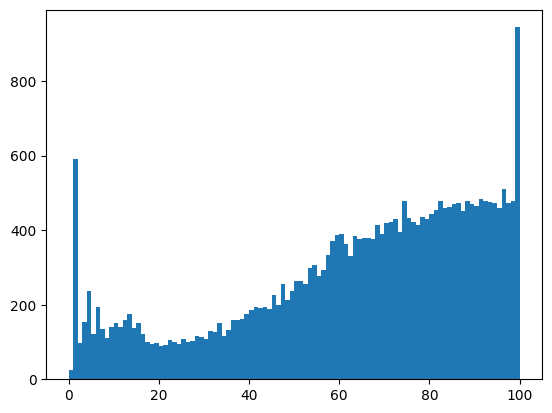

In [97]:
import matplotlib.pyplot as plt

plt.hist(df["sentences_len"], bins=100, range=(0, 100));

In [112]:
df_tmp = df[df["sentences_len"] < 40].reset_index(drop=True)

for i in range(50):
    print("-----"*12)
    print(df_tmp.iloc[i]['sentences'])

------------------------------------------------------------
This produces a semi-circular notch
------------------------------------------------------------
J
------------------------------------------------------------
Quant
------------------------------------------------------------
Spectrosc
------------------------------------------------------------
Radiat
------------------------------------------------------------
Transfer, 14, 691-707.
Scott, N.A
------------------------------------------------------------
and A
------------------------------------------------------------
J
------------------------------------------------------------
Appl
------------------------------------------------------------
Meteorol., 20, 802-812.
Chaumat, L., N
------------------------------------------------------------
Decoster, C
------------------------------------------------------------
Standfuss, B
------------------------------------------------------------
Tournier, R
-----------------------

In [110]:
np.sum(df["sentences_len"] < 65) / len(df)

0.12556

In [1]:
import pandas as pd

df_1 = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/wiki-sci-2-w-sentence-context/test_1.csv")

df_2 = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/wiki-sci-2-w-sentence-context/test_2.csv")

df = pd.concat([df_1, df_2]).reset_index(drop=True)

df.to_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/wiki-sci-2-w-sentence-context/test_1_and_2.csv")

df

,prompt,A,B,C,D,E,answer
0,Context: The homogeneously distributed mass of...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,"Context: To describe these systems, it is conv...",Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D
...,...,...,...,...,...,...,...
195,Context: Then the bending moments at the thr...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C
196,Context: Most liquids such as hydraulic oils w...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B
197,"Context: Instead, an examination of the micros...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B
198,Context: Under Sir Isaac Newton's -year-old la...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D


In [2]:
df['id'] = df.index
df

,prompt,A,B,C,D,E,answer,id
0,Context: The homogeneously distributed mass of...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,0
1,"Context: To describe these systems, it is conv...",Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,1
2,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,2
3,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,3
4,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,4
...,...,...,...,...,...,...,...,...
195,Context: Then the bending moments at the thr...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,195
196,Context: Most liquids such as hydraulic oils w...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,196
197,"Context: Instead, an examination of the micros...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,197
198,Context: Under Sir Isaac Newton's -year-old la...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,198


In [3]:
import pandas as pd

df_preds = pd.read_csv("../preds/deberta-v3-large-on-raw_questions_wiki_sci_1-eval-kaggle-all-folds-grad-accum-16-2/deberta-v3-data-wiki_sci-with-wiki-sentence-context-eval-kaggle-all-folds-grad-accum-128-60k-viktor-dataset-deotte-preproc-deberta-v3-large-2023-09-10-00-56-02-checkpoint-22500.csv")

df_preds

,id,score0,score1,score2,score3,score4,prediction
0,0,0.669055,0.383148,0.223418,-0.596123,-0.016895,D E C
1,1,-0.349094,0.499215,0.226862,0.759502,-0.024662,A E C
2,2,-0.385807,-0.329380,-0.473542,-0.679381,-0.238458,D C A
3,3,0.144181,0.637456,0.169556,0.466731,0.571204,A C D
4,4,0.182317,0.628030,0.521338,0.372514,0.402218,A D E
...,...,...,...,...,...,...,...
195,195,0.269599,0.373655,-0.475110,0.744473,0.087915,C E A
196,196,0.208946,-0.014819,-0.437087,0.435829,0.758373,C B A
197,197,-0.565335,-0.494394,-0.386578,-0.500957,-0.188601,A D B
198,198,0.490983,0.214010,0.207507,0.122672,0.809338,D C B


In [4]:
# join df and df_preds, using id as key
df_merged = df.merge(df_preds, on='id', how='left')
df_merged

,prompt,A,B,C,D,E,answer,id,score0,score1,score2,score3,score4,prediction
0,Context: The homogeneously distributed mass of...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,0,0.669055,0.383148,0.223418,-0.596123,-0.016895,D E C
1,"Context: To describe these systems, it is conv...",Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,1,-0.349094,0.499215,0.226862,0.759502,-0.024662,A E C
2,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,2,-0.385807,-0.329380,-0.473542,-0.679381,-0.238458,D C A
3,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,3,0.144181,0.637456,0.169556,0.466731,0.571204,A C D
4,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,4,0.182317,0.628030,0.521338,0.372514,0.402218,A D E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Context: Then the bending moments at the thr...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,195,0.269599,0.373655,-0.475110,0.744473,0.087915,C E A
196,Context: Most liquids such as hydraulic oils w...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,196,0.208946,-0.014819,-0.437087,0.435829,0.758373,C B A
197,"Context: Instead, an examination of the micros...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,197,-0.565335,-0.494394,-0.386578,-0.500957,-0.188601,A D B
198,Context: Under Sir Isaac Newton's -year-old la...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,198,0.490983,0.214010,0.207507,0.122672,0.809338,D C B


In [5]:
df_merged['is_correct_answer'] = df_merged[['answer', 'prediction']].apply(lambda x: x['answer'] == x['prediction'][0], axis=1)
df_merged

,prompt,A,B,C,D,E,answer,id,score0,score1,score2,score3,score4,prediction,is_correct_answer
0,Context: The homogeneously distributed mass of...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,0,0.669055,0.383148,0.223418,-0.596123,-0.016895,D E C,True
1,"Context: To describe these systems, it is conv...",Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,1,-0.349094,0.499215,0.226862,0.759502,-0.024662,A E C,True
2,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,2,-0.385807,-0.329380,-0.473542,-0.679381,-0.238458,D C A,False
3,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,3,0.144181,0.637456,0.169556,0.466731,0.571204,A C D,False
4,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,4,0.182317,0.628030,0.521338,0.372514,0.402218,A D E,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Context: Then the bending moments at the thr...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,195,0.269599,0.373655,-0.475110,0.744473,0.087915,C E A,True
196,Context: Most liquids such as hydraulic oils w...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,196,0.208946,-0.014819,-0.437087,0.435829,0.758373,C B A,False
197,"Context: Instead, an examination of the micros...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,197,-0.565335,-0.494394,-0.386578,-0.500957,-0.188601,A D B,False
198,Context: Under Sir Isaac Newton's -year-old la...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,198,0.490983,0.214010,0.207507,0.122672,0.809338,D C B,True


In [29]:
df_merged['is_correct_answer'] = df_merged[['answer', 'prediction']].apply(lambda x: x['answer'] == x['prediction'][0], axis=1)
df_merged

,prompt,A,B,C,D,E,answer,id,score0,score1,score2,score3,score4,prediction,is_correct_answer
0,Context: The homogeneously distributed mass of...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,0,0.702531,0.391031,0.160168,-0.569978,-0.054915,D E C,True
1,"Context: To describe these systems, it is conv...",Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,1,-0.144666,0.691206,0.047354,0.692092,0.141675,A C E,True
2,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,2,-0.255818,-0.328512,-0.346339,-0.828342,-0.143305,D C B,False
3,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,3,0.166124,0.624831,0.175648,0.463813,0.579668,A C D,False
4,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,4,0.180262,0.572748,0.589622,0.387132,0.376748,A E D,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Context: Then the bending moments at the thr...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,195,0.339222,0.399145,-0.410842,0.680495,0.306182,C E A,True
196,Context: Most liquids such as hydraulic oils w...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,196,0.206479,0.035858,-0.396881,0.420700,0.788402,C B A,False
197,"Context: Instead, an examination of the micros...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,197,-0.628087,-0.560910,-0.235854,-0.484188,-0.028679,A B D,False
198,Context: Under Sir Isaac Newton's -year-old la...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,198,0.573768,0.201688,0.205383,0.133662,0.755026,D B C,True


In [30]:
df_merged['min_score'] = df_merged[['score0', 'score1', 'score2', 'score3', 'score4']].apply(lambda x: min(x), axis=1)
df_merged

,prompt,A,B,C,D,E,answer,id,score0,score1,score2,score3,score4,prediction,is_correct_answer,min_score
0,Context: The homogeneously distributed mass of...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,0,0.702531,0.391031,0.160168,-0.569978,-0.054915,D E C,True,-0.569978
1,"Context: To describe these systems, it is conv...",Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,1,-0.144666,0.691206,0.047354,0.692092,0.141675,A C E,True,-0.144666
2,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,2,-0.255818,-0.328512,-0.346339,-0.828342,-0.143305,D C B,False,-0.828342
3,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,3,0.166124,0.624831,0.175648,0.463813,0.579668,A C D,False,0.166124
4,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,4,0.180262,0.572748,0.589622,0.387132,0.376748,A E D,False,0.180262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Context: Then the bending moments at the thr...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,195,0.339222,0.399145,-0.410842,0.680495,0.306182,C E A,True,-0.410842
196,Context: Most liquids such as hydraulic oils w...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,196,0.206479,0.035858,-0.396881,0.420700,0.788402,C B A,False,-0.396881
197,"Context: Instead, an examination of the micros...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,197,-0.628087,-0.560910,-0.235854,-0.484188,-0.028679,A B D,False,-0.628087
198,Context: Under Sir Isaac Newton's -year-old la...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,198,0.573768,0.201688,0.205383,0.133662,0.755026,D B C,True,0.133662


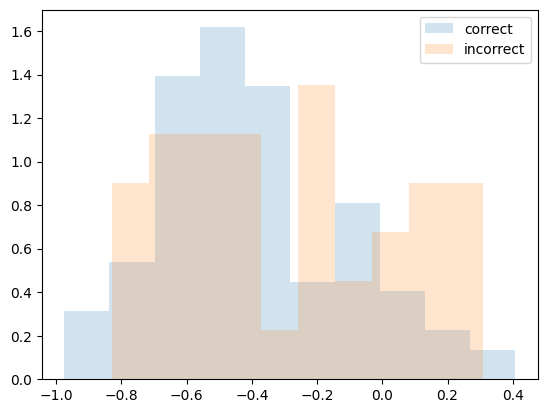

In [31]:
import matplotlib.pyplot as plt

plt.hist(df_merged[df_merged['is_correct_answer']]['min_score'],  density=True, alpha=0.2, label="correct");
plt.hist(df_merged[~df_merged['is_correct_answer']]['min_score'], density=True, alpha=0.2, label="incorrect");

plt.legend(loc='upper right')

In [6]:
df_merged['is_correct_answer'].mean()

0.79

In [ ]:
df_subset = df_merged[df_merged['is_correct_answer'] == False].reset_index(drop=True)
df_subset

In [33]:
df_subset = df_merged[df_merged['is_correct_answer'] == False].reset_index(drop=True)
df_subset

,prompt,A,B,C,D,E,answer,id,score0,score1,score2,score3,score4,prediction,is_correct_answer,min_score
0,"Context: ""Caput Medusae"" [Latin] means ""Head o...",The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,2,-0.255818,-0.328512,-0.346339,-0.828342,-0.143305,D C B,False,-0.828342
1,Context: (Another way to avoid the infinity...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,3,0.166124,0.624831,0.175648,0.463813,0.579668,A C D,False,0.166124
2,"Context: The finer the grating spacing, the gr...",The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,4,0.180262,0.572748,0.589622,0.387132,0.376748,A E D,False,0.180262
3,Context: The water pressure is a little great...,The pressure differential between the inside a...,The decrease in velocity resulting in an incre...,The movement of air across the outside surface...,The use of cold water,Bernoulli's principle,E,16,0.204377,0.241550,0.098519,0.910680,0.246656,C A B,False,0.098519
4,Context: Hooke suggested to Isaac Newton in 16...,Newton learned about tangential motion and rad...,Newton's manuscripts did not show any evidence...,Newton combined tangential motion with the eff...,Newton's manuscripts showed that he learned ab...,Newton's manuscripts showed that he was indebt...,C,23,0.049115,-0.591735,0.247478,0.124569,0.755430,B A D,False,-0.591735
5,Context: The technique of reverberation mappin...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,28,-0.029826,-0.450404,-0.040756,-0.780309,-0.430933,D B E,False,-0.780309
6,Context: The second law of thermodynamics stat...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,The second law of thermodynamics is a physical...,E,32,-0.438990,-0.067354,0.772516,0.305152,-0.335935,A E B,False,-0.438990
7,"Context: In July 2015, EGS-zs8-1 was surpassed...",The proper distance for a redshift of 8.2 is a...,The proper distance for a redshift of 8.2 is a...,The proper distance for a redshift of 8.2 is a...,The proper distance for a redshift of 8.2 is a...,The proper distance for a redshift of 8.2 is a...,C,41,-0.500391,-0.485160,-0.215647,-0.547569,-0.409748,D A B,False,-0.547569
8,"Context: Ultimately, the information loss due ...",Black holes have an infinite number of interna...,Black holes have an infinite number of interna...,Black holes have only a few internal parameter...,Black holes have only a few internal parameter...,Black holes have only a few internal parameter...,C,43,0.694300,0.569081,0.061691,-0.177685,0.398392,D C E,False,-0.177685
9,"Context: At higher temperatures, they behave l...",Intrinsic semiconductors,Electrical impedance tomography,Quantum conduction,Carrier mobility,Variable range hopping,E,51,0.351155,0.836431,-0.053479,0.411977,0.066995,C E A,False,-0.053479


Analyze wrong answers:

- `indx = 0`: not in the topic of science.
- `indx = 1`: equation is needed to be included to give more detailed context
- `indx = 2`: GPT4 corectly predicts C, as it should be!
- `indx = 3`: WTF?! Again?! The answer is correct, but it's labeled as wrong.
- `indx = 4`: It almost got it right. these are the logits (0.160744, 0.15902). The model was confused since the context was not good. The context did not reveal if the propagation constant is a constant or it changes
- `indx = 5`: ok this was clearly wrong. 
- `indx = 6`: almost close! e was "more correct".
- `indx = 7`: clearly wrong, even if it says so in the context!
- `indx = 8`: model was wrong, it got confused by the wrong topics

In [79]:
indx = 7

df_subset = df_merged[df_merged['is_correct_answer'] == False].reset_index(drop=True).iloc[indx]

print('prompt', "----"*24)
print(df_subset['prompt'])
print('Answer', "----"*24)
print(df_subset[df_subset['answer']])
print("\n")
print('A', "----"*24)
print(df_subset['A'])
print('b', "----"*24)
print(df_subset['B'])
print('c', "----"*24)
print(df_subset['C'])
print('d', "----"*24)
print(df_subset['D'])
print('e', "----"*24)
print(df_subset['E'])

prompt ------------------------------------------------------------------------------------------------
Context: The technique of reverberation mapping uses variability of these lines to measure the mass and perhaps the spin of the black hole that powers active galaxies.

In the Milky Way 

Astronomers are confident that the Milky Way galaxy has a supermassive black hole at its center, 26,000 light-years from the Solar System, in a region called Sagittarius A* because:
 The star S2 follows an elliptical orbit with a period of 15.2 years and a pericenter (closest distance) of 17 light-hours ( or 120 AU) from the center of the central object.
 From the motion of star S2, the object's mass can be estimated as , or about .
 The radius of the central object must be less than 17 light-hours, because otherwise S2 would collide with it. The latter is thought to be composed of stars and stellar remnants.

The comparatively small mass of this supermassive black hole, along with the low luminosit